<a href="https://colab.research.google.com/gist/carlthome/c635d6e96c2542bdc47d0f0d7373551d/noise2music-inspired-automatic-music-captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# noise2music-inspired automatic music captioning

In [noise2music](https://google-research.github.io/noise2music/), the training dataset is created by pseudo-labeling a vast collection of unlabeled music audio using two advanced deep learning models. A large language model generates a diverse set of general music-related descriptive sentences to serve as potential captions. These captions are then matched to individual music clips through zero-shot classification, leveraging a pre-trained joint embedding model designed for music and text.

So being curious, let's try the following:

1. Generate a lot of music descriptions with a Meta Llama 3.2 LLM.
1. Embed the generated music descriptions with a LAION CLAP text encoder.
1. Index the text embeddings for nearest neighbor retrieval with FAISS.
1. Use the corresponding audio encoder to embed an audio example.
1. Use the audio embedding as search query for retrieving text embeddings.

**Could this simple method produce reasonable audio captions?**

In [1]:
pip install -q datasets faiss-cpu

In [2]:
import torch
import faiss
import transformers
import datasets
import polars as pl
import librosa as lr
import numpy as np
import tqdm.auto as tqdm
import seaborn as sns

# Configure plotting.
pl.Config.set_fmt_str_lengths(256)
sns.set_style("ticks")
sns.set_theme("notebook")

# Download some example audio files.
dataset = datasets.load_dataset("marsyas/gtzan", trust_remote_code=True)

# Download a pretrained text generation model.
text_generator = transformers.pipeline(
    task="text-generation",
    model="meta-llama/Llama-3.2-1B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# Download a pretrained CLAP model.
clap_model = transformers.ClapModel.from_pretrained("laion/larger_clap_general")
clap_processor = transformers.ClapProcessor.from_pretrained("laion/larger_clap_general")

In [3]:
# Generate a lot of music descriptions.
messages = [
    {"role": "system", "content": "You are a music reviewer who is specific, brief and accurate."},
    {"role": "user", "content": "Imagine any random piece of music and describe how it sounds in one sentence without mentioning the name or artist."},
]
descriptions = text_generator(
    messages,
    num_return_sequences=1000,
    return_full_text=False,
    do_sample=True,
    num_beams=1,
    max_new_tokens=32,
)
descriptions = pl.DataFrame(descriptions)

# Save the descriptions to file.
descriptions.write_parquet("music_descriptions.parquet")
descriptions.sample()

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


shape: (1, 1)
┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ generated_text                                                                                   │
│ ---                                                                                              │
│ str                                                                                              │
╞══════════════════════════════════════════════════════════════════════════════════════════════════╡
│ The piece features a haunting piano melody, punctuated by sparse strings and a subtle, pulsing   │
│ bass line that creates an eerie, atmospheric backdrop for a whispered vocal                      │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

In [4]:
num_dimensions = clap_model.config.projection_dim
index = faiss.IndexFlatL2(num_dimensions)

In [5]:
# Tokenize text descriptions.
inputs = clap_processor(text=descriptions["generated_text"].to_list(), return_tensors="pt", padding=True)

# Populate local vector database.
batch_size = 8
for i in tqdm.trange(0, len(inputs["input_ids"]), batch_size, desc="Indexing descriptions"):
    input_ids = inputs["input_ids"][i:i + batch_size]
    attention_mask = inputs["attention_mask"][i:i + batch_size]

    # Embed the tokens.
    text_embeddings = clap_model.get_text_features(input_ids, attention_mask)

    # Add embeddings to the index.
    index.add(text_embeddings.numpy(force=True))

Indexing descriptions:   0%|          | 0/125 [00:00<?, ?it/s]

In [6]:
# Load an example audio file.
audio_file = lr.example("trumpet")
waveform, samplerate = lr.load(audio_file, sr=clap_processor.feature_extractor.sampling_rate)

# Compute audio embedding.
inputs = clap_processor(audios=waveform, return_tensors="pt", sampling_rate=clap_processor.feature_extractor.sampling_rate)
audio_embedding = clap_model.get_audio_features(**inputs)
audio_embedding.shape

torch.Size([1, 512])

In [7]:
# Search for similar embeddings.
max_results = 1000
similarities, neighbor_ids = index.search(audio_embedding.numpy(force=True), k=max_results)
similarities.shape

(1, 1000)

In [8]:
# Lookup underlying text descriptions.
matches = descriptions[neighbor_ids[0][:max_results]].with_columns(pl.Series("scores", similarities[0][:max_results]))
matches.top_k(5, by="scores")

shape: (5, 2)
┌───────────────────────────────────────────────────────────────────────────────────────┬──────────┐
│ generated_text                                                                        ┆ scores   │
│ ---                                                                                   ┆ ---      │
│ str                                                                                   ┆ f32      │
╞═══════════════════════════════════════════════════════════════════════════════════════╪══════════╡
│ This piece of music features a haunting, atmospheric arrangement of eerie whispers    ┆ 2.301279 │
│ and dissonant harmonies, punctuated by sudden, percussive bursts of sound that        ┆          │
│ The piece is a haunting, atmospheric soundscape of pulsing synthesizers, eerie        ┆ 2.252909 │
│ whispers, and a steady, pulsing heartbeat, evoking a sense of fore                    ┆          │
│ This piece features a haunting, atmospheric soundscape of whispers and creaks,        ┆ 2.249522 │
│ punctuated by a sparse, pulsing rhythm that gradually builds into a crescendo         ┆          │
│ The piece features a mesmerizing blend of eerie whispers, pulsating electronic beats, ┆ 2.237405 │
│ and haunting vocal harmonies that create an unsettling atmosphere, gradually building ┆          │
│ towards a dis                                                                         ┆          │
│ This 5-minute composition features a gradual build-up of atmospheric textures, with   ┆ 2.235468 │
│ layers of haunting piano and whispery vocals gradually giving way to a driving,       ┆          │
│ pulsing                                                                               ┆          │
└───────────────────────────────────────────────────────────────────────────────────────┴──────────┘

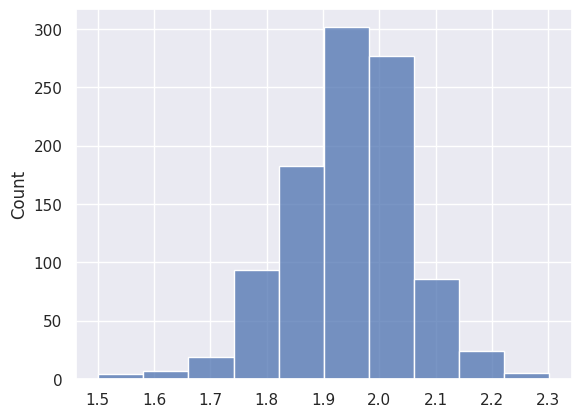

In [9]:
sns.histplot(similarities[0], bins=max_results//100);